In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import h5py

In [71]:
# Plot style parameters
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=16)          # text size
plt.rc('axes', titlesize=20)     # axes title size
plt.rc('axes', labelsize=20)     # axes label size
plt.rc('xtick', labelsize=16)    # x-tick label size
plt.rc('ytick', labelsize=16)    # y-tick label size
plt.rc('legend', fontsize=18)    # legend font size
plt.rc('figure', titlesize=16)   # figure title size

In [72]:
#%ls ../Team32025/WLI_With_Glass_20251015/ # list data folder/files
#%ls ..\Team32025\

In [73]:
def extract_mat_data(folder):
    '''
    This is the first function I tried to pull the data out of the .mat files.
    It generally works fine, but requires you to pull the data by first calling
    the function with a file path as input. It then looks in that file and extracts
    the data from each file that ends with the .mat extension. This is called as follows:
    > path = '/this/is/the/path/to/the/data/and/is/a/string'
    > data = extract_mat_data(path)   
    To then pull the extracted data, you use the filename as a key. You can run 
    > data.keys()
    to see which keys are availible. As said above, these are going to be the filenames
    of the .mat file from which the data were extracted. They are strings, so use '' or "". 
    To then look at the way the data is structured, you can take one of these keys 
    and run the following:
    > data['key'].items()
    This gives you a general idea as to the structure of the data inside of each .mat file. 
    To then look at a specfic piece of data, like if you wanted to plot it for instance, 
    it starts to get a bit convoluted. You have to add the item name onto the end like so:
    > data['key']['item']
    As an example, with the 'raw_data' files in the WLI data we took, you will get an item 
    called 'dataArray' which is [2048,2] array, where each column is a different set of data 
    from the HeNe source and the White Light source respectively. So in order to plot one 
    of those datasets, you would need to grab each column separately. This is done like so
    (assuming matplotlib.pyplot has been imported as plt):
    > HeNeData = data['raw_data_file']['dataArray'][:,0] # first col: HeNe source
    > WLData = data['raw_data_file']['dataArray'][:,1] # second col: White Light source
    > fig, ax = plt.subplots(1,1, figsize=(8,6))
    > ax.plot(HeNeData, label='HeNe')
    > ax.plot(WLData, label='White Light')
    > ax.legend()
    > plt.show()
    As you can see, calling the data the way it is extracted by this function quickly becomes 
    cumbersome and inefficient. So I'd recommend not using this function. I do have it saved 
    just in case it proves useful for some other reason.
    '''
    data_dict = {}

    for filename in os.listdir(folder):
        if filename.endswith('.mat'):
            file_path = os.path.join(folder, filename)
            file_key = os.path.splitext(filename)[0]

            try:
                # Load scipy.io (for most MATLAB files)
                mat_data = sio.loadmat(file_path)
                
                # Filter out MATLAB metadata keys that start with '__'
                clean_data = {k: v for k, v in mat_data.items() if not k.startswith('__')}
                
                data_dict[file_key] = clean_data

            except NotImplementedError:
                # If loadmat fails, it's likely a v7.3 (HDF5-based) file
                with h5py.File(file_path, 'r') as f:
                    h5_data = {}
                    def recursively_load(name, obj):
                        if isinstance(obj, h5py.Dataset):
                            h5_data[name] = np.array(obj)
                    f.visititems(recursively_load)
                    data_dict[file_key] = h5_data

            except Exception as e:
                print(f"Error reading {filename}: {e}")

    return data_dict

In [74]:
# Makes use of extract_mat_data() function. Can ignore. 

#path = '/home/james/Desktop/WLI/Team32025/WLI_With_Glass_20251015/'
#path = '../Team32025/WLI_With_Glass_20251015/'
#data = extract_mat_data(path)

#print(data.keys())

## Inspect files
#for key in data.keys():
#    print(f"File: {key}")
#    for var_name, var_data in data[key].items():
#        print(f"  {var_name}: shape {var_data.shape}, dtype {var_data.dtype}")

# In case you wanted to see how you call a specfic piece of data
# This calls the HeNe source data from 'raw_data_004_20251015'. 
#data['raw_data_004_20251015']['dataArray'][:,0]

In [75]:
def extract_data(folder):
    '''
    This is a better data extraction function to use for this project. 
    In particular this extracts the dataArray columns from each file 
    and assigns them to variable names; which are the filename appended 
    with either '_HN_data' or '_WL_data' respectively. This is just for
    easier plotting through a loop since there two time the number of files
    of data that need to be plotted before averaging.
    '''
    data_dict = {}

    for filename in os.listdir(folder):
        if filename.endswith('.mat'):
            file_path = os.path.join(folder, filename)
            file_key = os.path.splitext(filename)[0]

            try:
                # Try loading with scipy.io (for most MATLAB files)
                mat_data = sio.loadmat(file_path)
                clean_data = {k: v for k, v in mat_data.items() if not k.startswith('__')}

            except NotImplementedError:
                # If it's a v7.3 (HDF5-based) file, use h5py
                with h5py.File(file_path, 'r') as f:
                    clean_data = {}
                    def recursively_load(name, obj):
                        if isinstance(obj, h5py.Dataset):
                            clean_data[name] = np.array(obj)
                    f.visititems(recursively_load)

            # Extract 'dataArray' key from file structure
            if 'dataArray' in clean_data:
                arr = clean_data['dataArray']
                if arr.ndim == 2 and arr.shape[1] >= 2:
                    HN_data = arr[:, 0]
                    WL_data = arr[:, 1]

                    data_dict[f'{file_key}_HN_data'] = HN_data
                    data_dict[f'{file_key}_WL_data'] = WL_data

            # Metadata stored here incase it is needed here later for some reason
            meta = {}
            for key in ['runTime', 'xCenCorrection', 'xLinear', 'xLinearStage']:
                if key in clean_data:
                    meta[key] = clean_data[key]
            data_dict[f'{file_key}_meta'] = meta

    return data_dict

In [78]:
# Specific path on my office computer. Can ignore
#path = '/home/james/Desktop/WLI/Team32025/WLI_With_Glass_20251015/'

# This path should work generally on your computer, 
# given you downloaded the full repository.
path = '../Team32025/WLI_With_Glass_20251015/'
data = extract_data(path)

# Below is just messing around and making sure seemed copacetic. 
# If you want to mess around with this, just uncomment anything below. 
# It is a bit disorganized, so you might have to deliberate about 
# what you are trying to look at. 

#print(data.keys())
#data2plot = []
#for key in data.keys():
#    if key.endswith('_HN_data') or key.endswith('_WL_data'):
#        data2plot.append(key)

# Word of warning, this will make 50 plots. That being said, it is fast.
# This plots the HeNe and WL data on separate plots, which is useful for
# a prelimary look, but not the final analysis. 
#for dataname in data2plot:
#    plt.figure(figsize=(10, 5))
#    plt.plot(data[dataname], color='k', alpha=0.8)
#    plt.xlabel('Distance [bins]')
#    plt.ylabel('Intensity [units]')
#    plt.title(dataname,  fontweight='bold')
#    plt.grid(True)
#    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
#    plt.show()
    #print(data[dataname])

# Just looking at one files raw data
#data1HN = data['raw_data_007_20251015_HN_data']
#data1WL = data['raw_data_007_20251015_WL_data']
#metadata = data['raw_data_007_20251015_meta']
#print(metadata.keys())  # -> dict_keys(['runTime', 'xCenCorrection', ...])

#fig, ax = plt.subplots(1,1, figsize=(10,8))

#ax.plot(data1HN, color='k', alpha=0.8) # first column is HeNe
#ax.plot(data1WL, color='r', alpha=0.8) # second column is WL
#ax.set_xlabel('Distance [a.u]', fontweight='bold')
#ax.set_ylabel('Intensity [units]',  fontweight='bold')
#ax.grid(True)
#plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
#plt.show()

# Plots of Raw Data

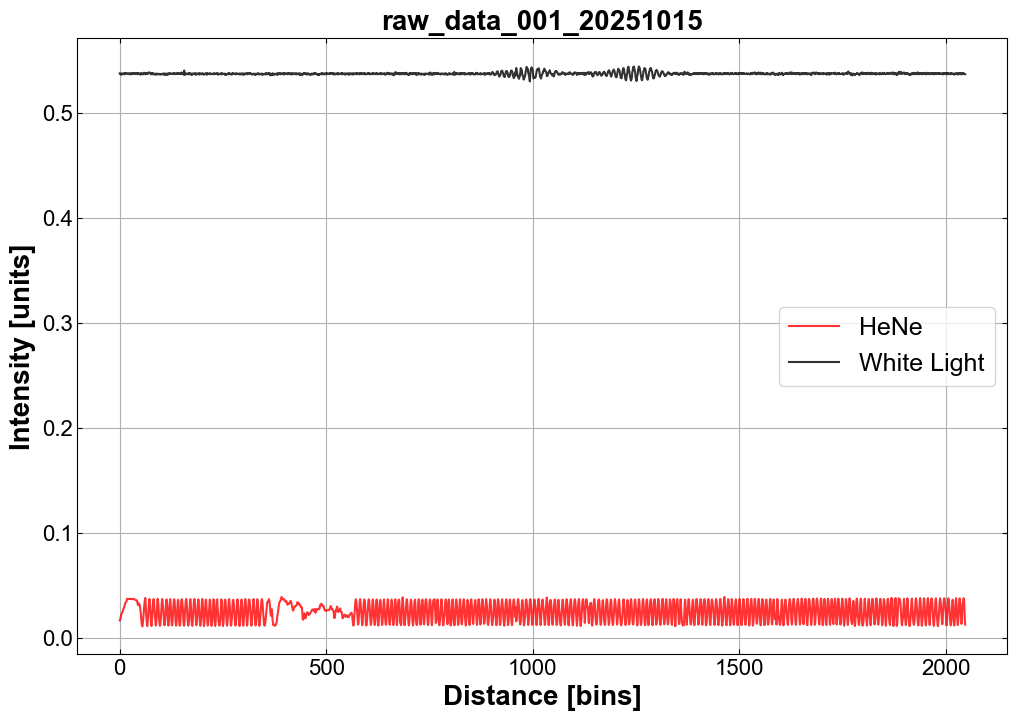

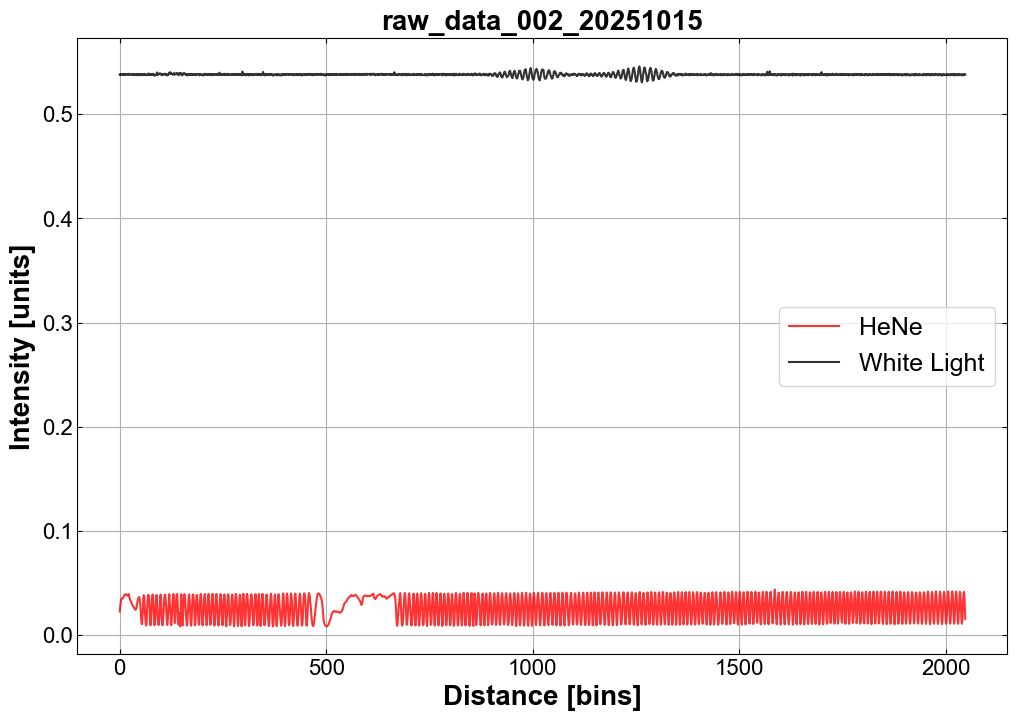

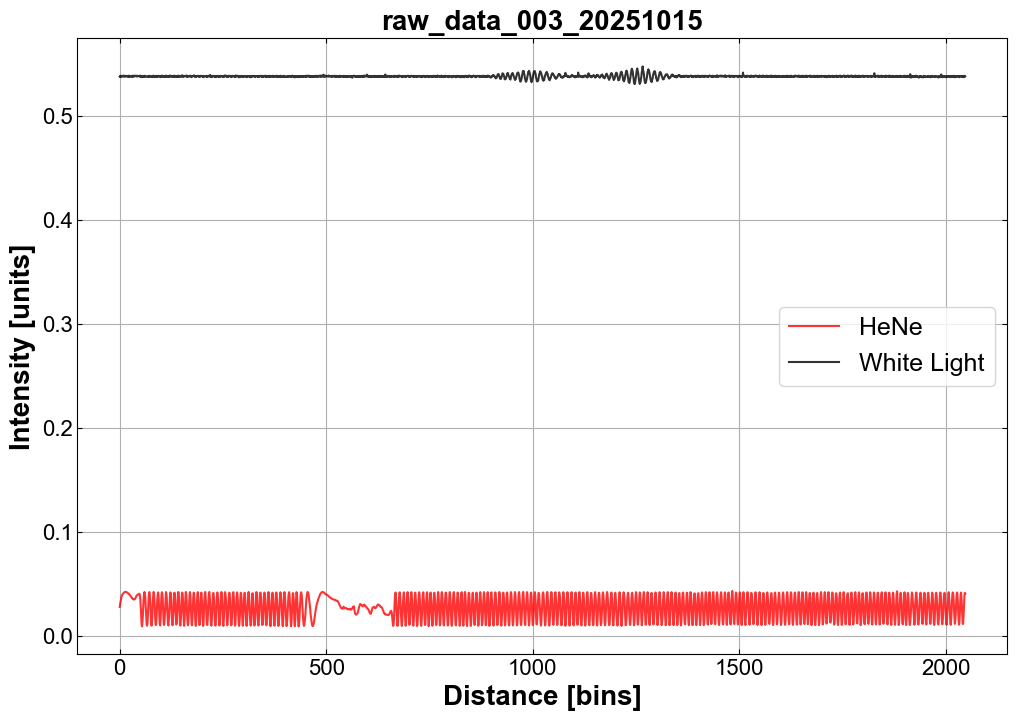

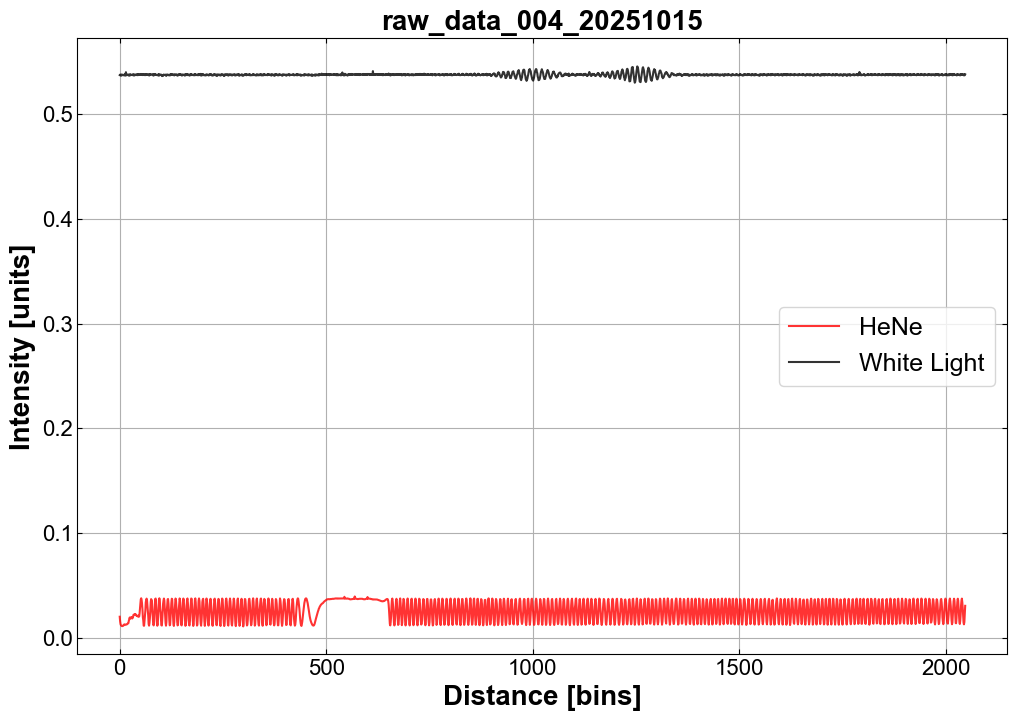

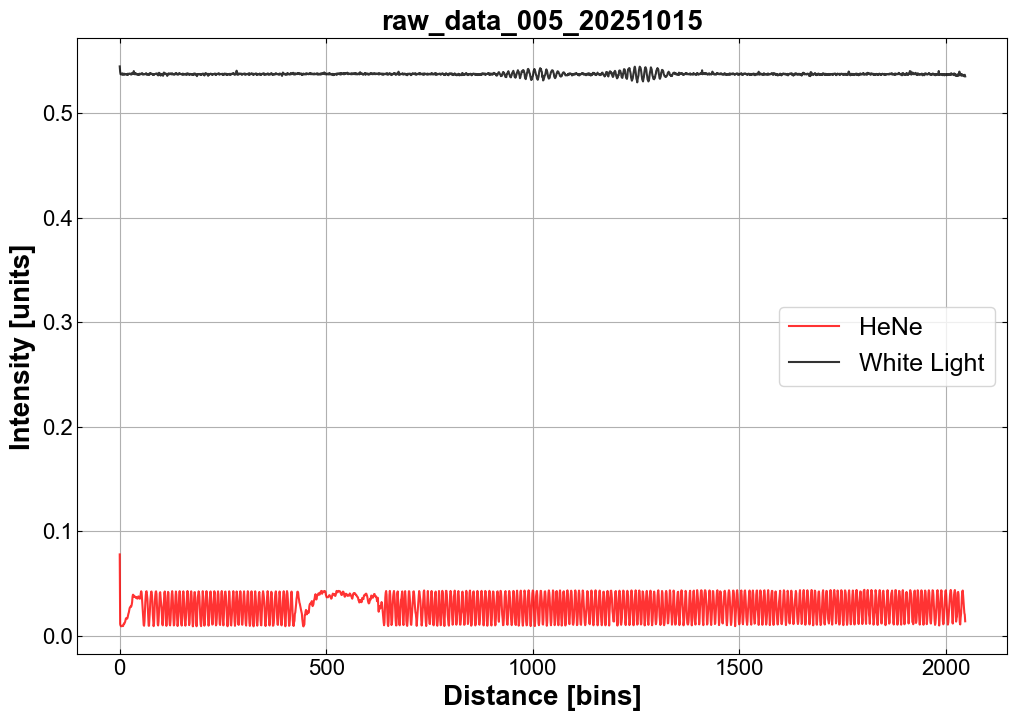

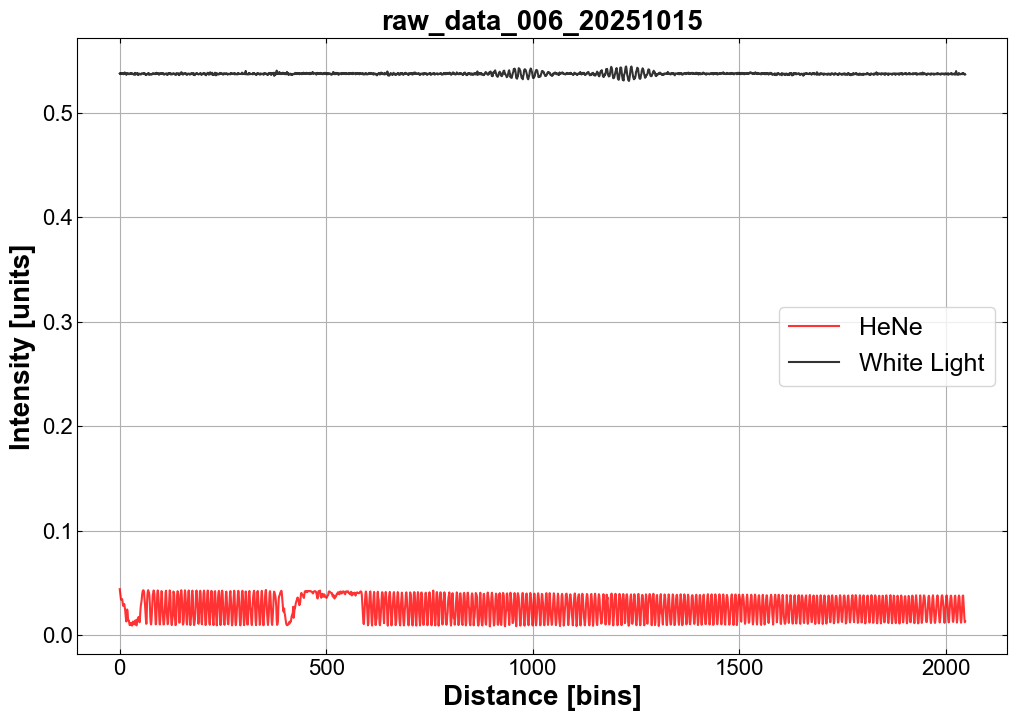

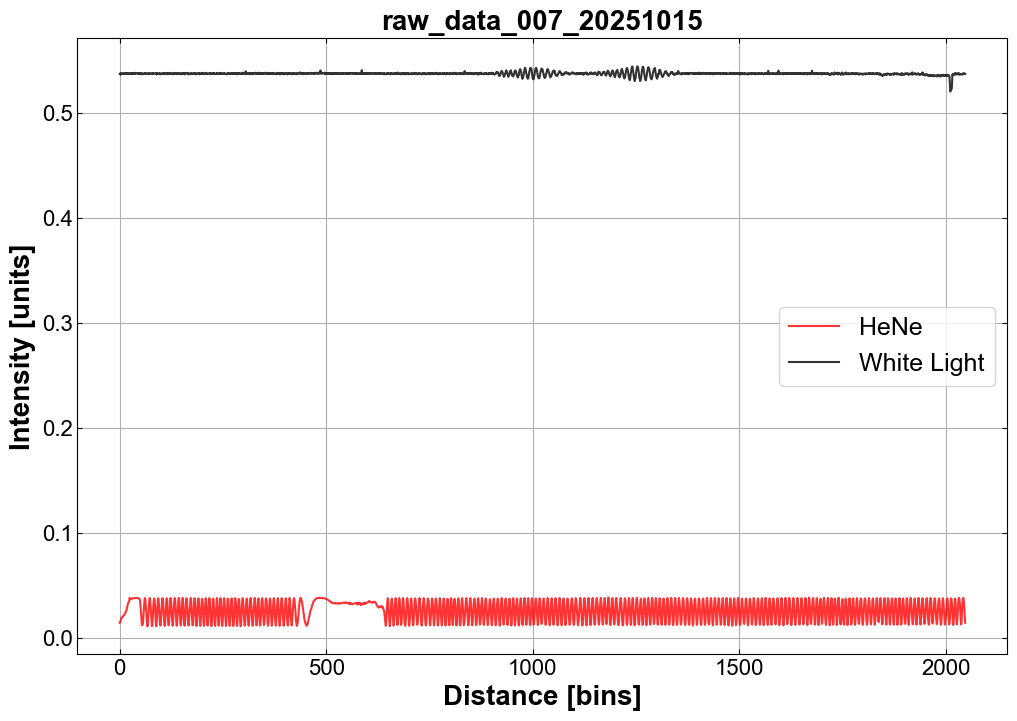

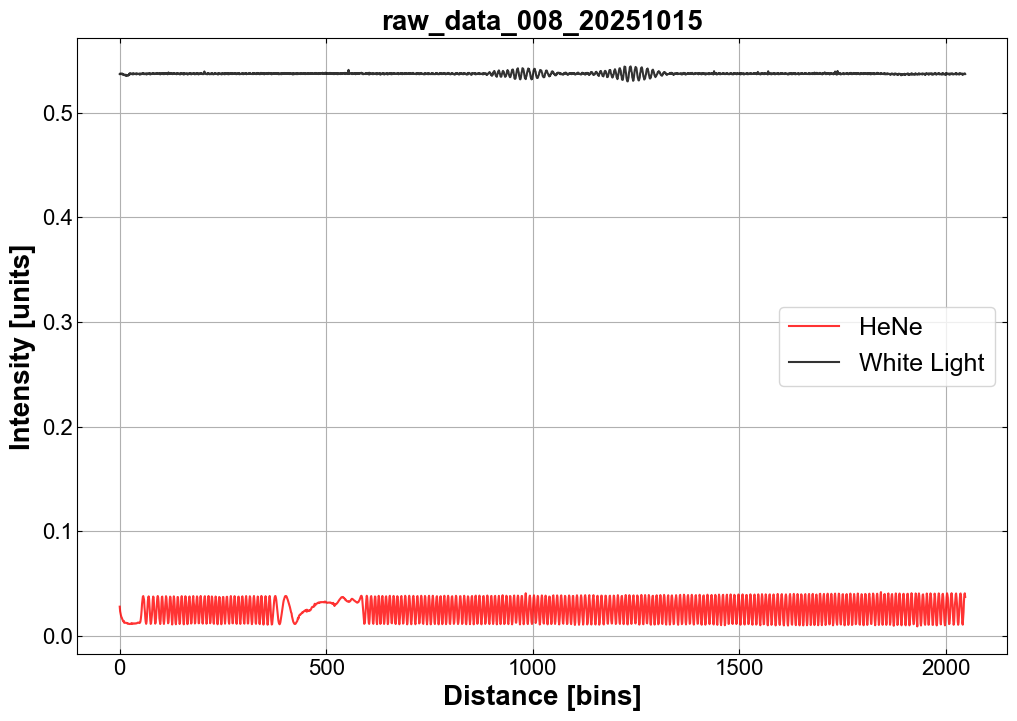

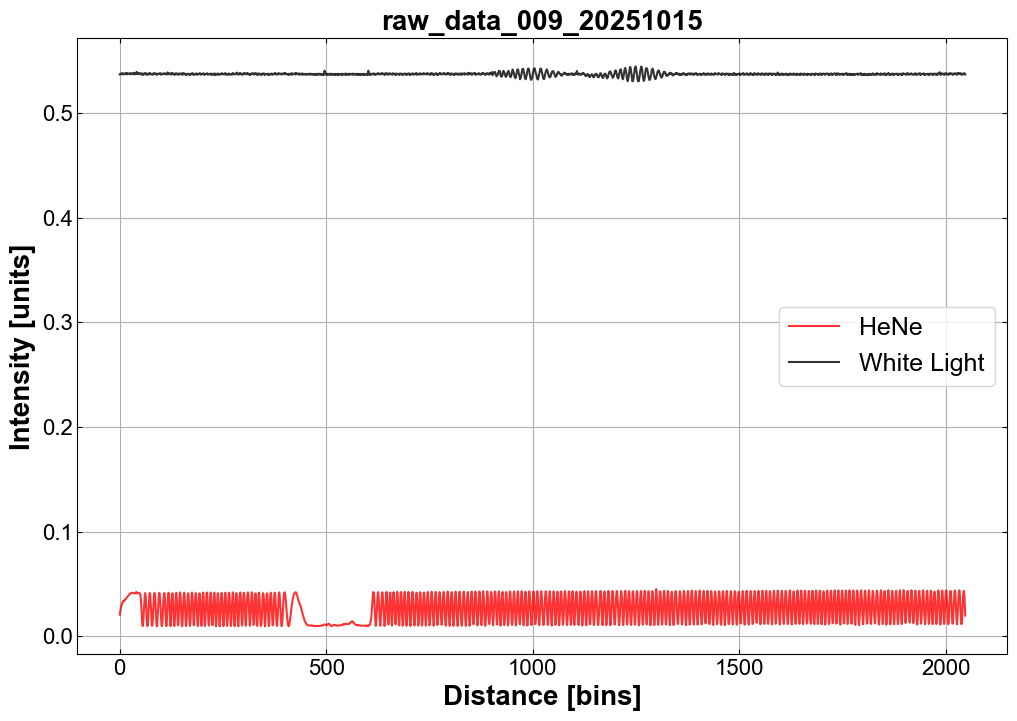

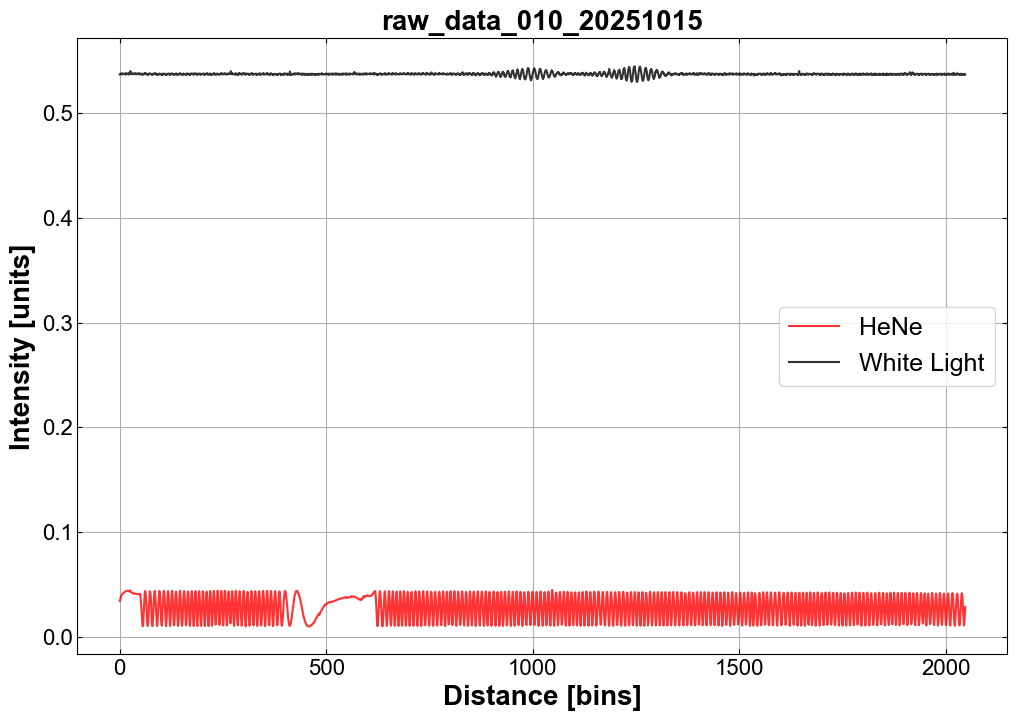

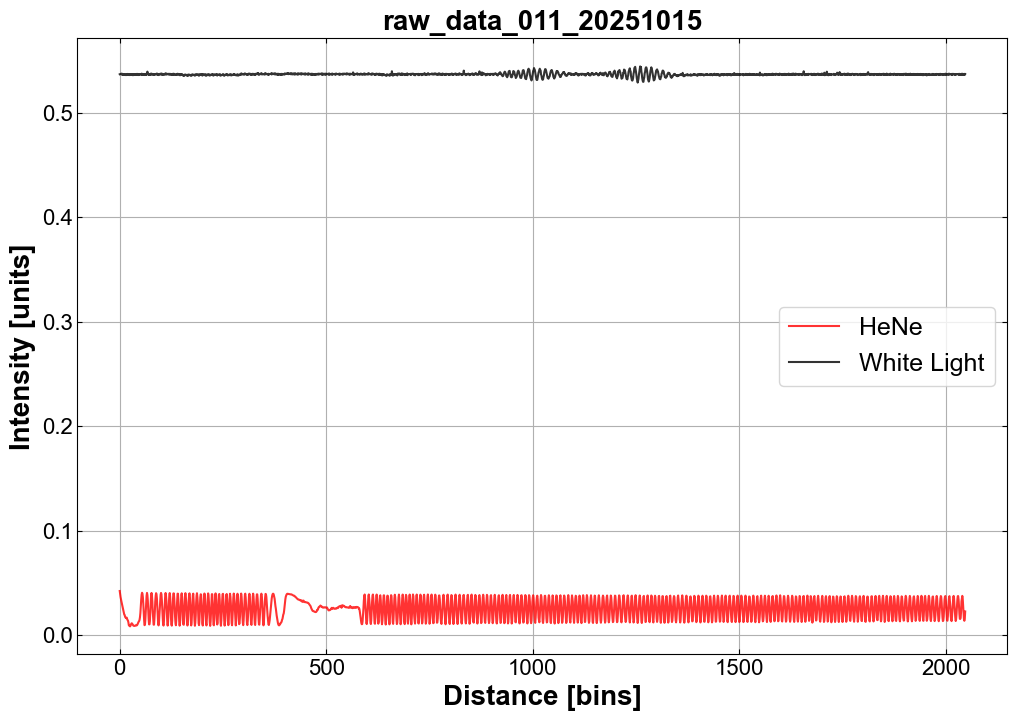

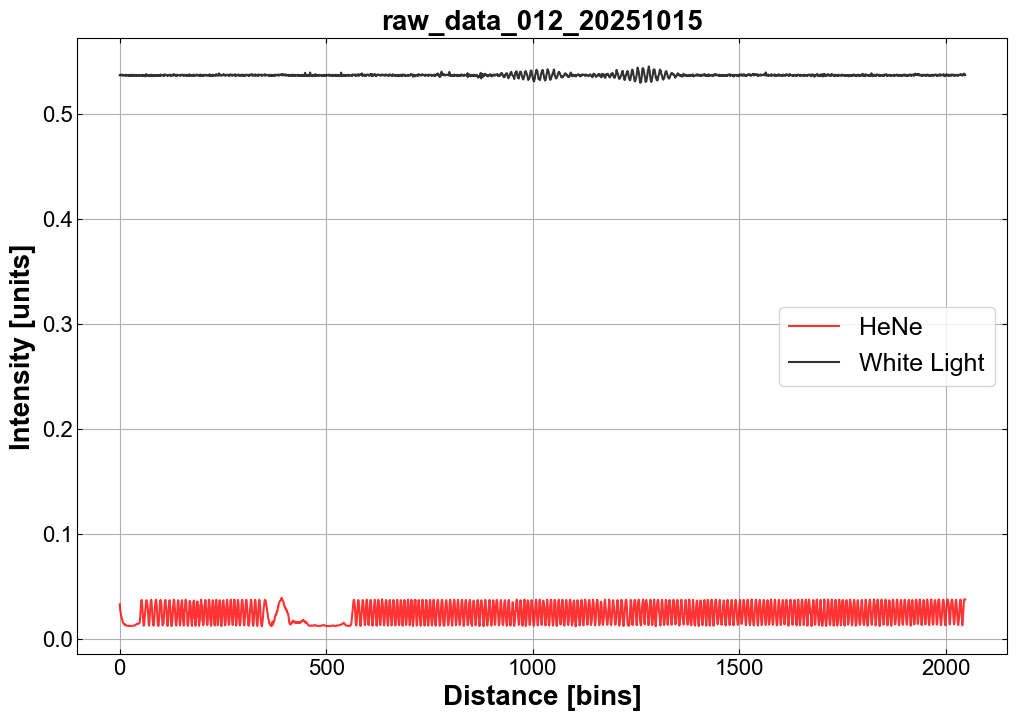

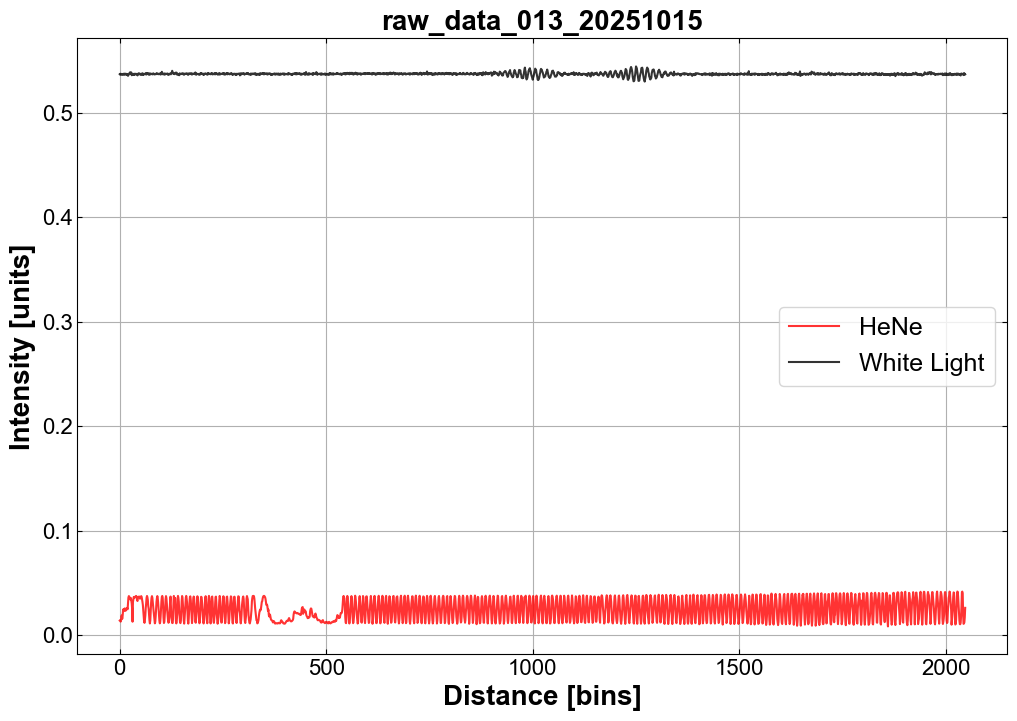

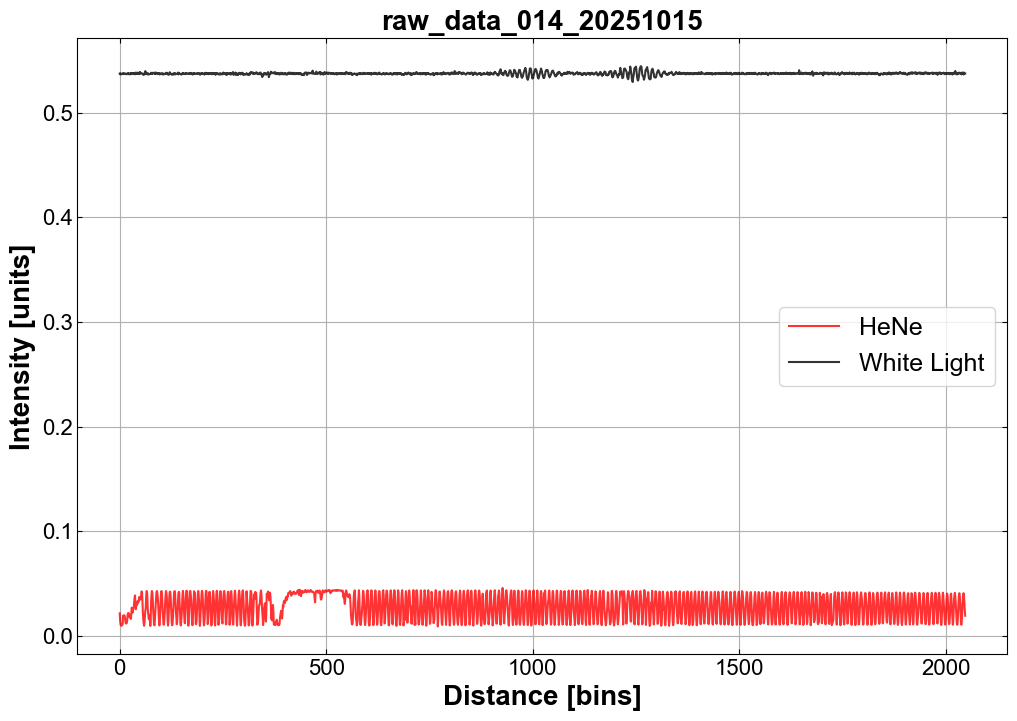

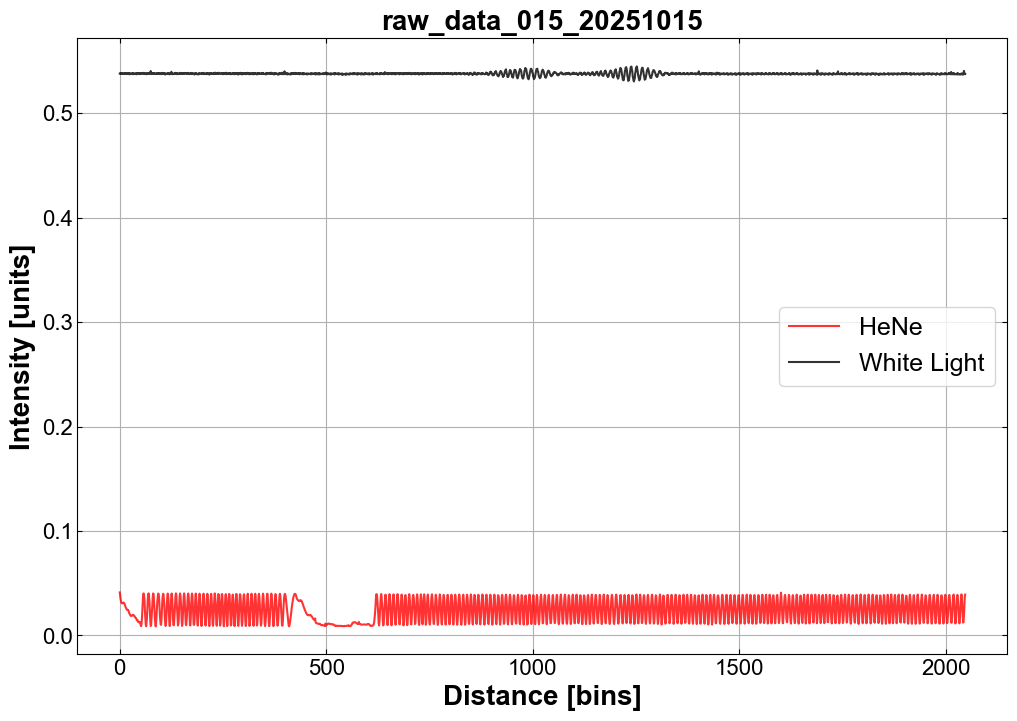

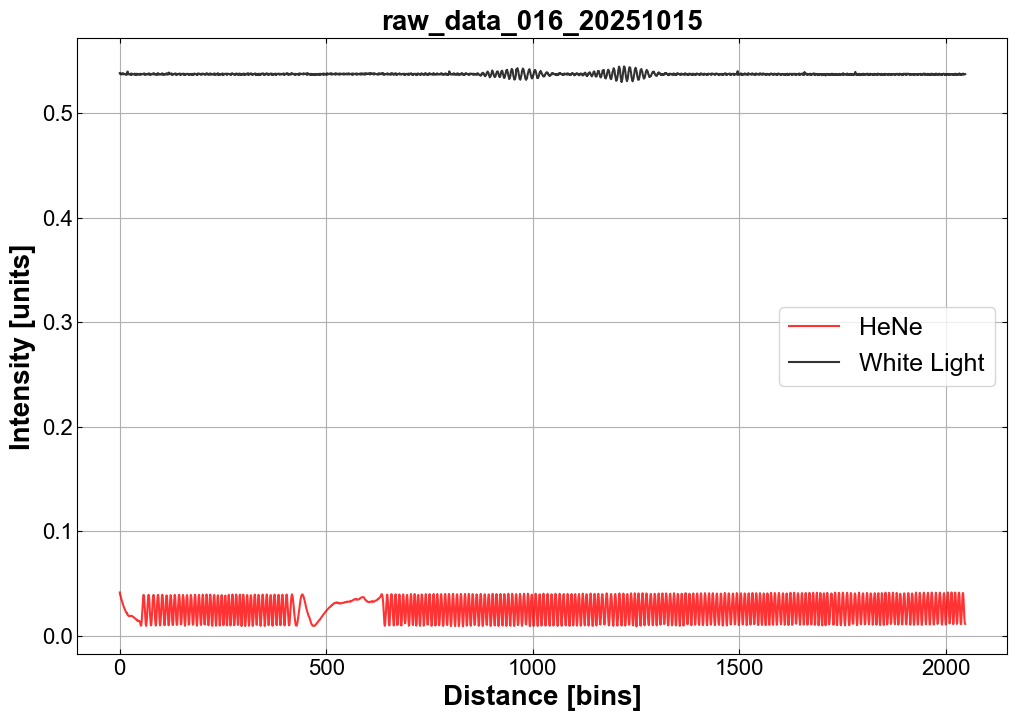

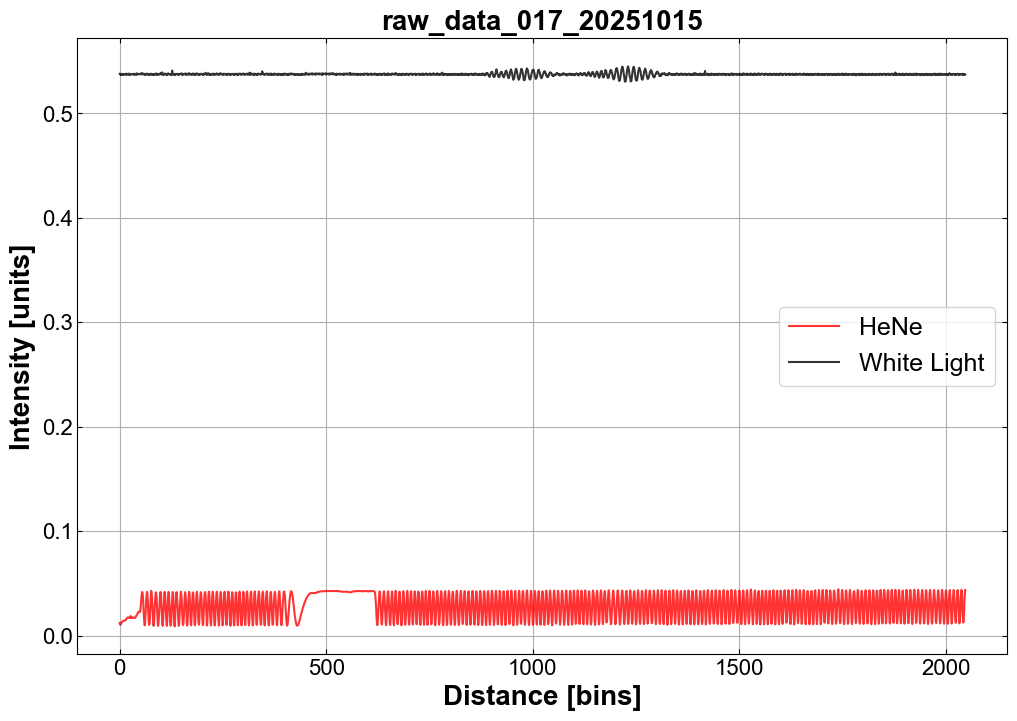

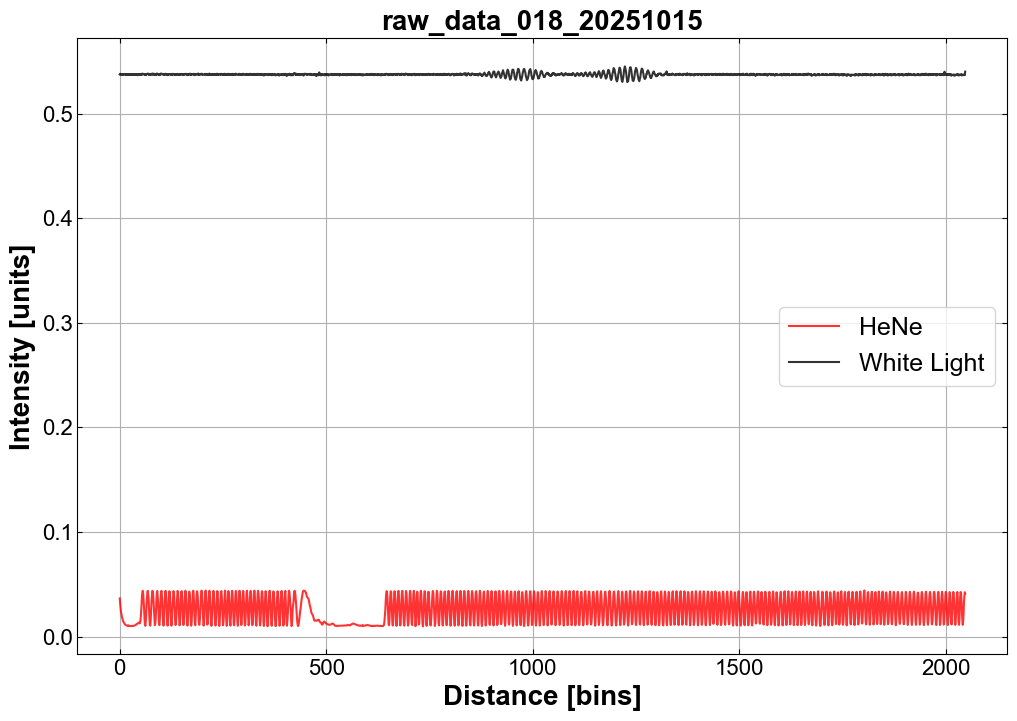

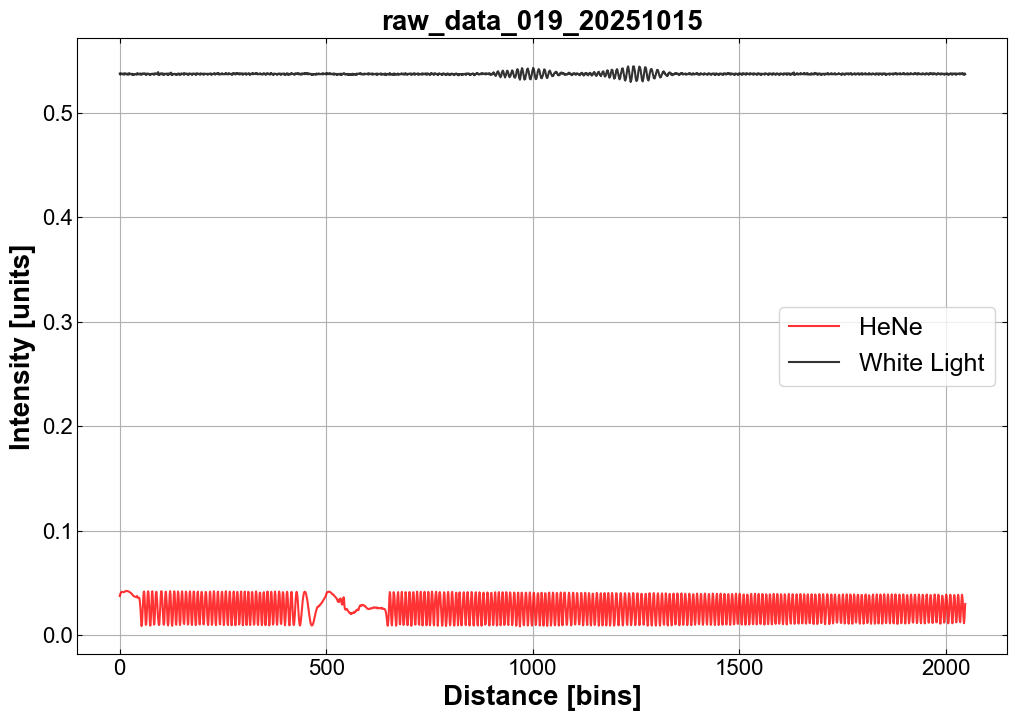

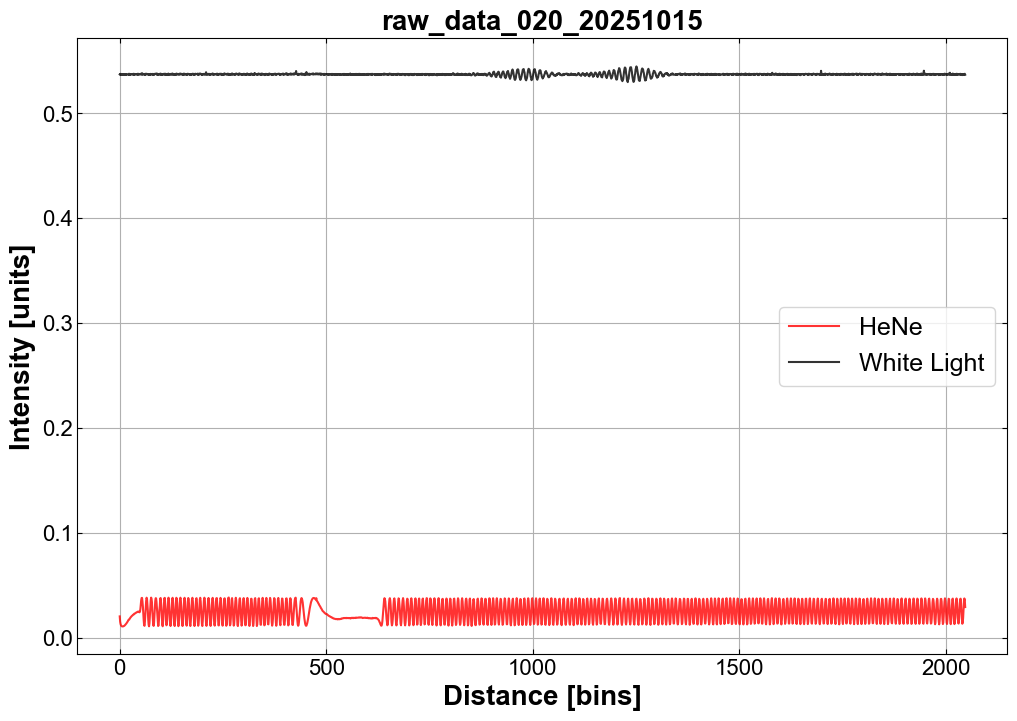

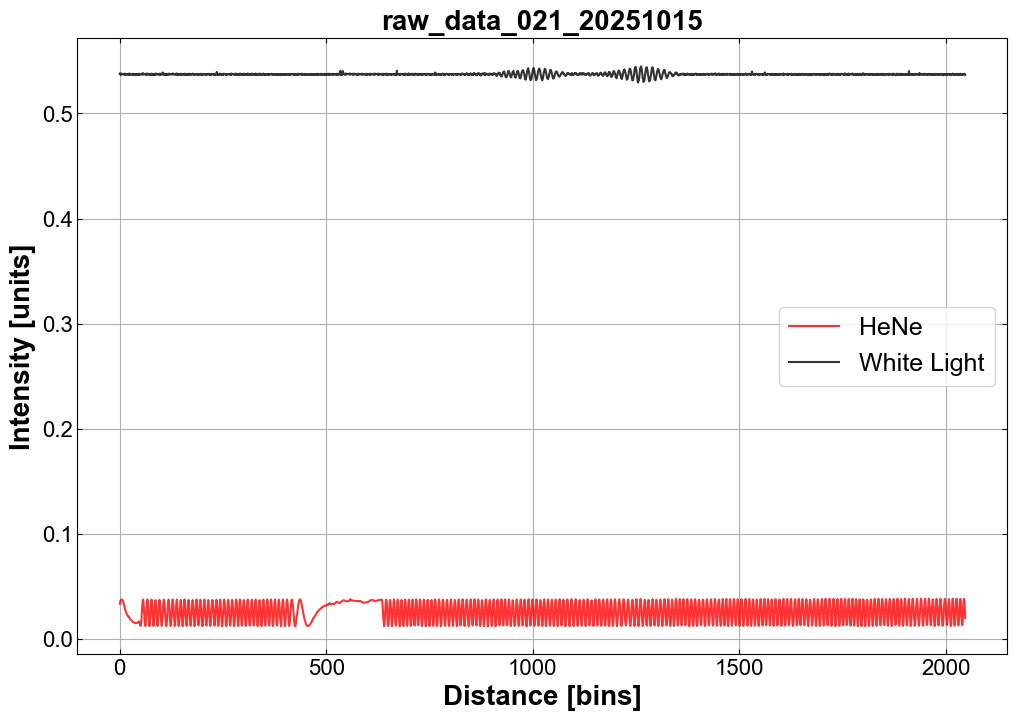

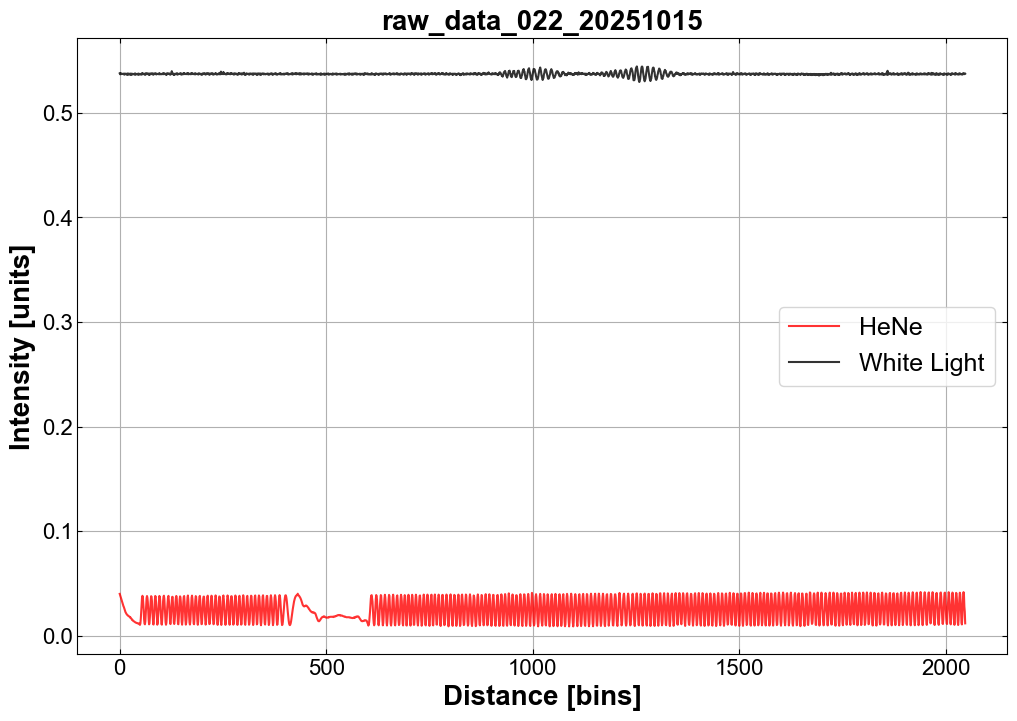

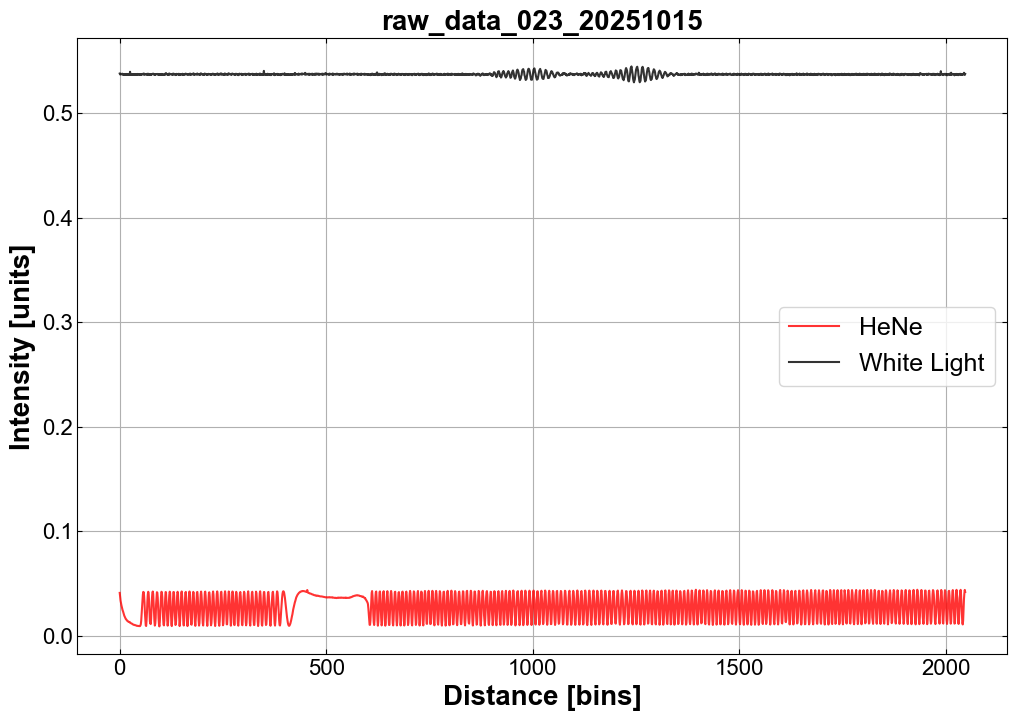

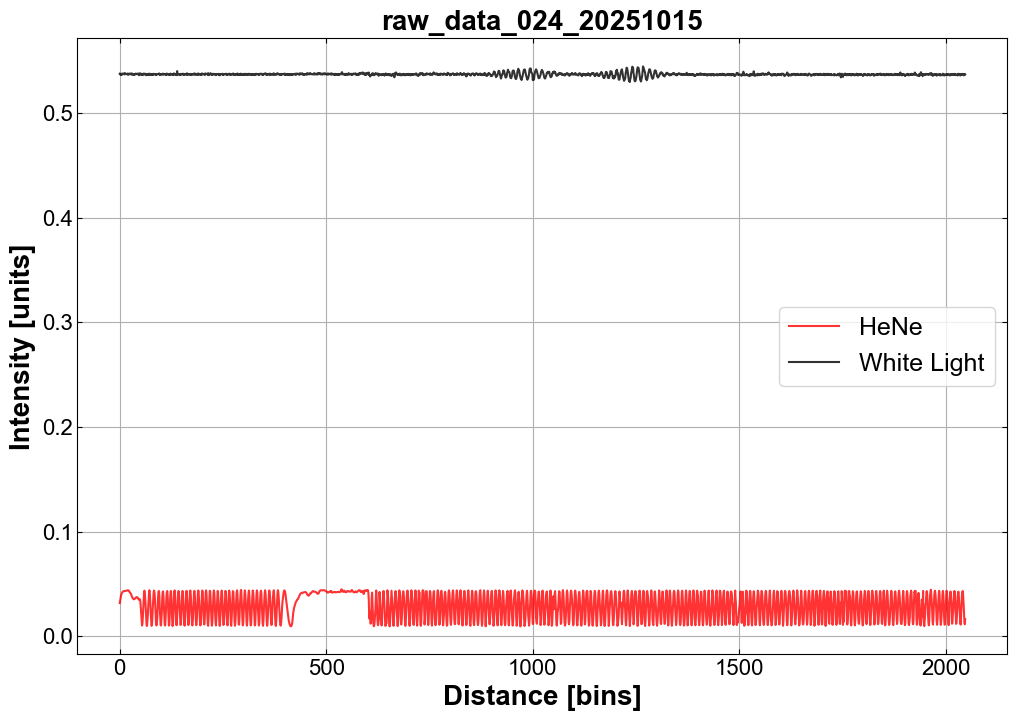

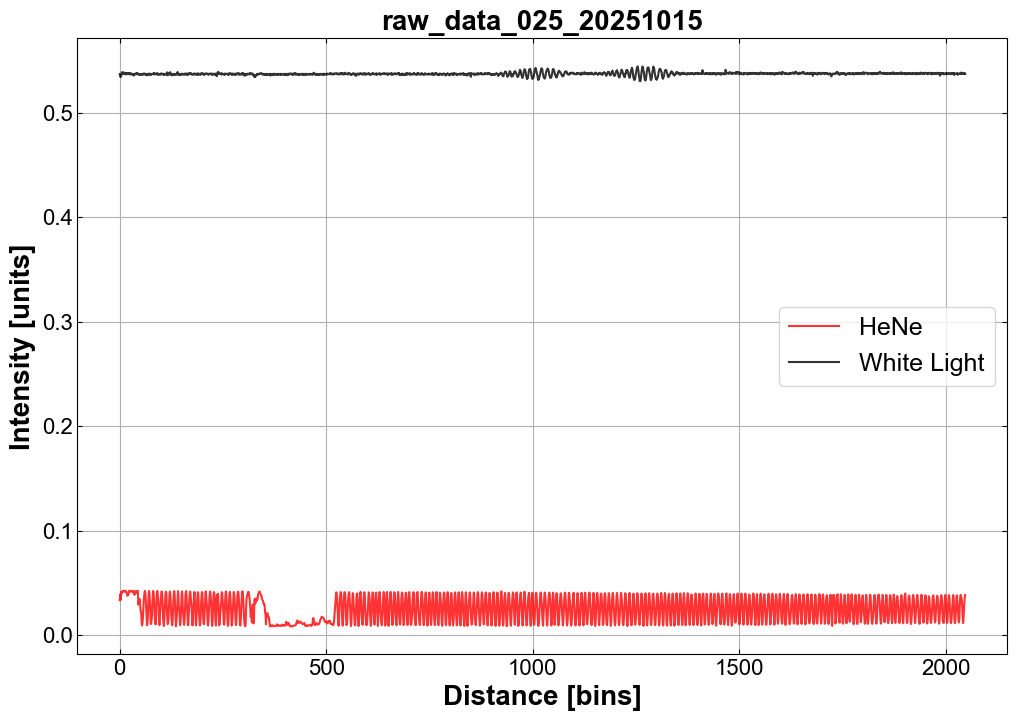

In [79]:
# This is stupid and should really probably be part of the extract_data() function.
# Basically, we need to take the base_key (key without the variable extension) 
# and reapply an extension to it, otherwise we will get duplicates because each file
# key has two variables that correspond to it. 

for key in sorted(data.keys()):
    if key.endswith('_HN_data'):
        base_key = key[:-8]
        wl_key = f'{base_key}_WL_data'
        #print(key)
        if wl_key in data:
            plt.figure(figsize=(12,8))
            plt.plot(data[key], label='HeNe', color='red', alpha=0.8)
            plt.plot(data[wl_key], label='White Light', color='black', alpha=0.8)
            plt.xlabel('Distance [bins]', fontweight='bold')
            plt.ylabel('Intensity [units]', fontweight='bold')
            plt.title(base_key, fontweight='bold')
            plt.legend()
            plt.grid(True)
            plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
            plt.show()

# Averaging raw data

In [84]:
# Look at metadata for a few files
for i, key in enumerate(sorted(data.keys())):
    if key.endswith('_meta'):
        print(f"\n{key}:")
        meta = data[key]
        for meta_key, meta_value in meta.items():
            print(f"  {meta_key}: {meta_value}")
        if i >= 2:  # first 3 files
            break

# Thank holy fuck! Same xCenCorrection, xLinear, and xLinearStage. 
# So averaging should be relatively simple.


processed_data_001_20251015_meta:
  runTime: ['20251015']
  xCenCorrection: [[0]]
  xLinear: [[-0.0768   -0.076725 -0.07665  ...  0.076575  0.07665   0.076725]]
  xLinearStage: [[-0.070491 ]
 [-0.0703262]
 [-0.0701614]
 ...
 [ 0.0701072]
 [ 0.070176 ]
 [ 0.0702584]]

processed_data_002_20251015_meta:
  runTime: ['20251015']
  xCenCorrection: [[0]]
  xLinear: [[-0.0768   -0.076725 -0.07665  ...  0.076575  0.07665   0.076725]]
  xLinearStage: [[-0.0704774]
 [-0.0703126]
 [-0.0701478]
 ...
 [ 0.0701346]
 [ 0.0702034]
 [ 0.0702858]]

processed_data_003_20251015_meta:
  runTime: ['20251015']
  xCenCorrection: [[0]]
  xLinear: [[-0.0768   -0.076725 -0.07665  ...  0.076575  0.07665   0.076725]]
  xLinearStage: [[-0.0705184]
 [-0.07034  ]
 [-0.0702026]
 ...
 [ 0.0700798]
 [ 0.0701486]
 [ 0.0702172]]


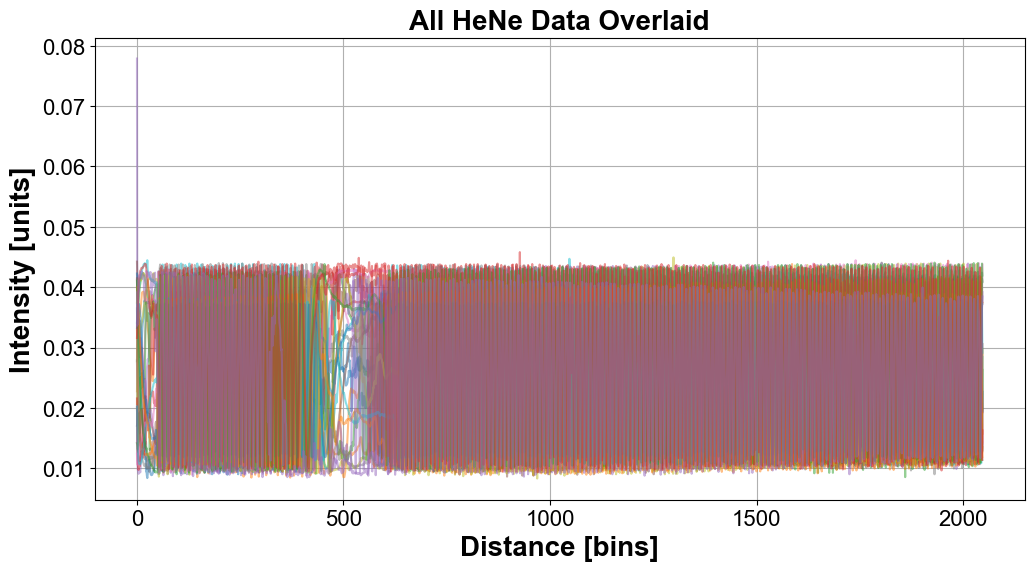

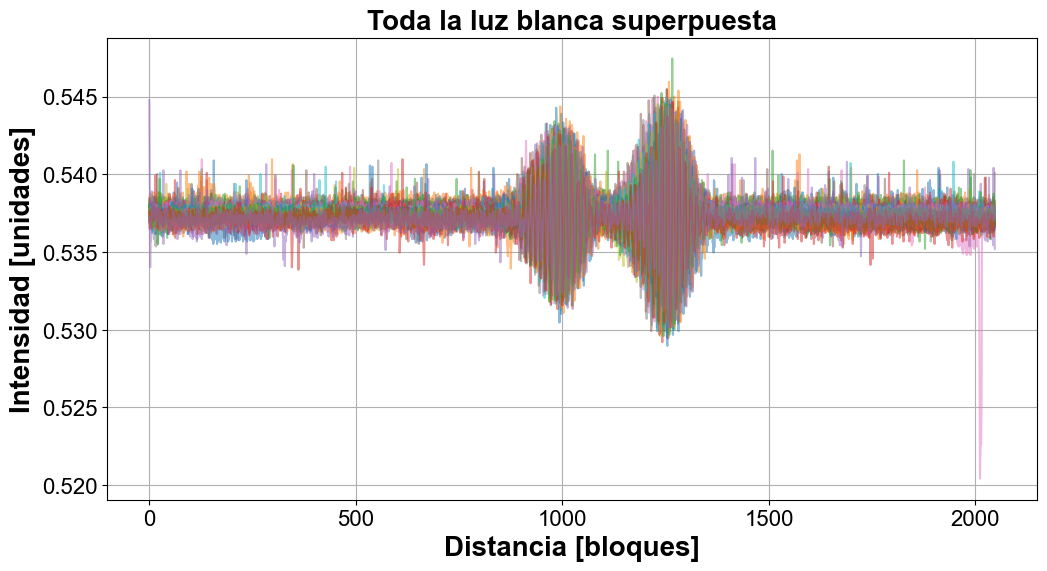

In [89]:
# Take all HN_data arrays to see if they have different baselines

hn_arrays = []
wl_arrays = []
labels = []

for key in sorted(data.keys()):
    if key.endswith('_HN_data'):
        base_key = key[:-8]
        wl_key = f'{base_key}_WL_data'
        
        if wl_key in data:
            hn_arrays.append(data[key])
            wl_arrays.append(data[wl_key])
            labels.append(base_key)

# Overlay all HN data on one plot to see variations
plt.figure(figsize=(12, 6))
for i, (hn, label) in enumerate(zip(hn_arrays, labels)):
    plt.plot(hn, alpha=0.5, label=label if i < 5 else None)  # Only label first 5 to avoid clutter
plt.xlabel('Distance [bins]', fontweight='bold')
plt.ylabel('Intensity [units]', fontweight='bold')
plt.title('All HeNe Data Overlaid', fontweight='bold')
if len(labels) <= 5:
    plt.legend()
plt.grid(True)
plt.show()

# WL data overlaid
plt.figure(figsize=(12, 6))
for i, (wl, label) in enumerate(zip(wl_arrays, labels)):
    plt.plot(wl, alpha=0.5, label=label if i < 5 else None)
plt.xlabel('Distancia [bloques]', fontweight='bold')
plt.ylabel('Intensidad [unidades]', fontweight='bold')
plt.title('Toda la luz blanca superpuesta', fontweight='bold')
if len(labels) <= 5:
    plt.legend()
plt.grid(True)
plt.show()

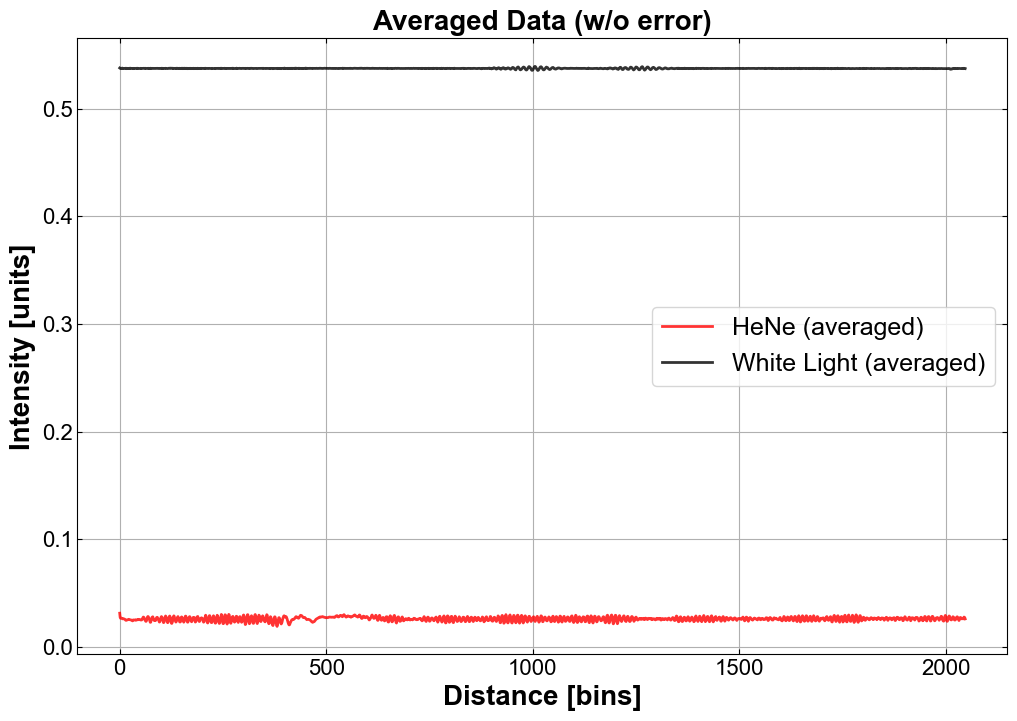

In [91]:
# Convert to numpy arrays
hn_arrays = np.array(hn_arrays)
wl_arrays = np.array(wl_arrays)

# Take average of all data
hn_avg = np.mean(hn_arrays, axis=0)
wl_avg = np.mean(wl_arrays, axis=0)

# Compute standard deviation to see uncertainty
hn_std = np.std(hn_arrays, axis=0)
wl_std = np.std(wl_arrays, axis=0)

# Plot averaged data without std error
plt.figure(figsize=(12, 8))
plt.plot(hn_avg, label='HeNe (averaged)', color='red', alpha=0.8, linewidth=2)
plt.plot(wl_avg, label='White Light (averaged)', color='black', alpha=0.8, linewidth=2)
plt.xlabel('Distance [bins]', fontweight='bold')
plt.ylabel('Intensity [units]', fontweight='bold')
plt.title('Averaged Data (w/o Uncertainty)', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.show()

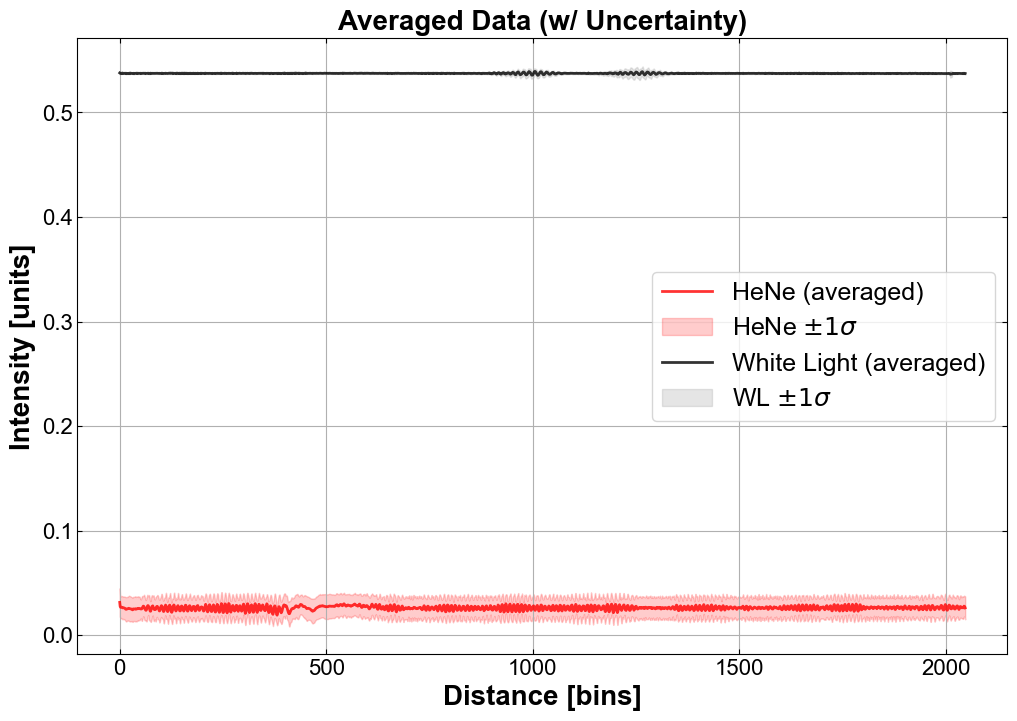

In [95]:
# Plot averaged data with std error
plt.figure(figsize=(12, 8))
plt.plot(hn_avg, label='HeNe (averaged)', color='red', alpha=0.8, linewidth=2)
plt.fill_between(range(len(hn_avg)), hn_avg - hn_std, hn_avg + hn_std, 
                 color='red', alpha=0.2, label=r'HeNe $\pm 1 \sigma$')
plt.plot(wl_avg, label='White Light (averaged)', color='black', alpha=0.8, linewidth=2)
plt.fill_between(range(len(wl_avg)), wl_avg - wl_std, wl_avg + wl_std, 
                 color='gray', alpha=0.2, label=r'WL $\pm 1 \sigma$')
plt.xlabel('Distance [bins]', fontweight='bold')
plt.ylabel('Intensity [units]', fontweight='bold')
plt.title('Averaged Data (w/ Uncertainty)', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.show()

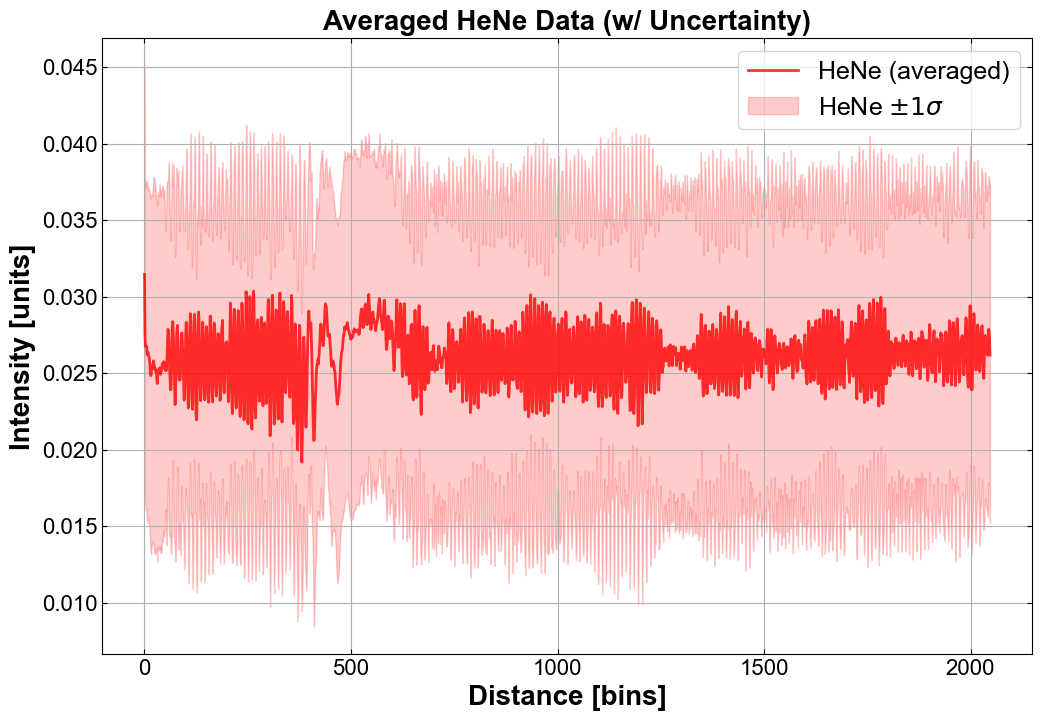

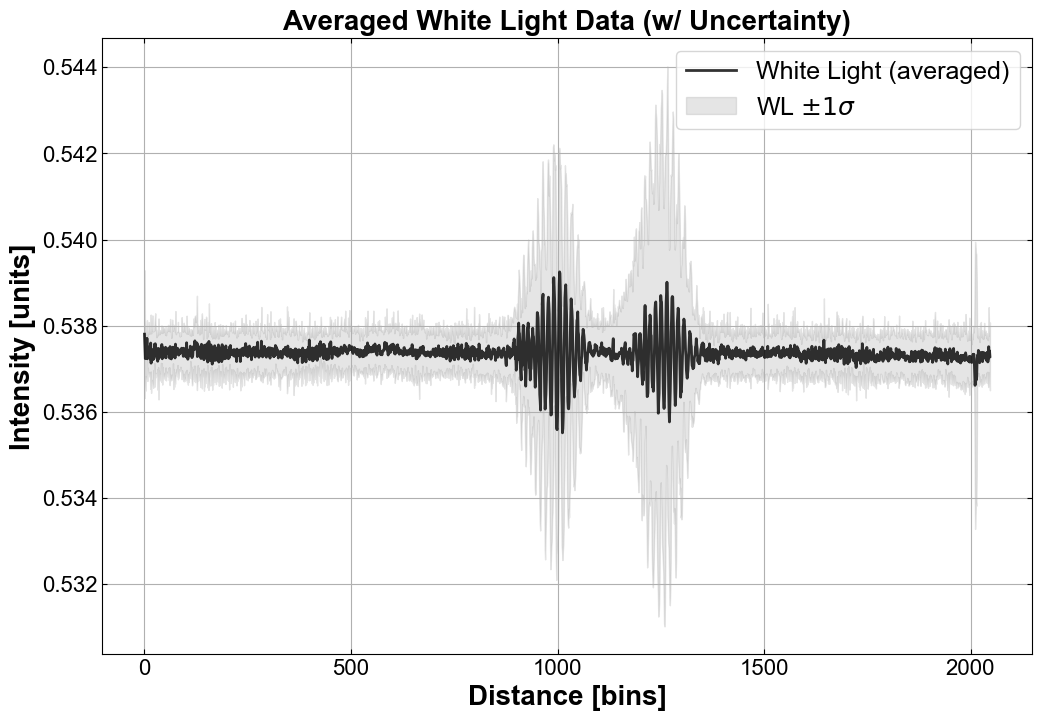

In [97]:
# Individual plots so data can be seen more clearly
plt.figure(figsize=(12, 8))
plt.plot(hn_avg, label='HeNe (averaged)', color='red', alpha=0.8, linewidth=2)
plt.fill_between(range(len(hn_avg)), hn_avg - hn_std, hn_avg + hn_std, 
                 color='red', alpha=0.2, label=r'HeNe $\pm 1 \sigma$')
plt.xlabel('Distance [bins]', fontweight='bold')
plt.ylabel('Intensity [units]', fontweight='bold')
plt.title('Averaged HeNe Data (w/ Uncertainty)', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(wl_avg, label='White Light (averaged)', color='black', alpha=0.8, linewidth=2)
plt.fill_between(range(len(wl_avg)), wl_avg - wl_std, wl_avg + wl_std, 
                 color='gray', alpha=0.2, label=r'WL $\pm 1 \sigma$')
plt.xlabel('Distance [bins]', fontweight='bold')
plt.ylabel('Intensity [units]', fontweight='bold')
plt.title('Averaged White Light Data (w/ Uncertainty)', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.show()